# 2. Modeling

## Overview

The train and test data sets I am using I am using are from Birds' Songs Numeric Dataset.

__Data Dictionary__

This data set comes in two parts - a train.csv and test.csv

The train set is fairly well balanced though we note over representation in a few categories.

The test set has been further enhanced by to present a significantly greater class imbalance(see References section).

Both sets consist of the following features:

id - integer and primary key
chromograms - 156 in total positive floats between 0 and 1
spectral centroid - 12 features, positive values between 1000 and 4400 

and two targets: "genus" and "species"

For our preliminary exploration we are using 1000 observations and focusing on the target "genus". 



## Exploratory Analysis

In [1]:
# Loading the necessaries 

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import os # accessing directory structure
import pandas as pd 

%matplotlib inline

import statsmodels.api as sm 

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# let's have a look at all the columns
pd.set_option('display.max_columns', 200)

In [2]:
print(os.listdir('./input'))

['test.csv', 'train.csv', 'xcmeta.csv']


The starter notebook for these datasets helpfully supplied some plotting code.

In [3]:
# Plot Per Column Distribution aka Per Feature Distribution 
#
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [4]:
# Plot Correlation Matrix
#
# 
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [5]:
'''
        In preparing this plot, we will
        grab only numerical columns - ignoring text
        ignores columns with one-only values
        ignores columns with less than 10 values for dimensionality reduction
        
'''
# Scatter and Density Plots
# 
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
   
    

Now that we have some visualization functionality, Let's see what we can learn about the data

### The Test Data

In [6]:
# Read the test file: toggle n_rows = 1000 for protyping
nRowsRead = 1000 # specify 'None' if want to read whole file
# test.csv has 16626 rows in reality, but we are only loading/previewing the first 1000 rows for prototyping
# we set the index to be id 
df1 = pd.read_csv('./input/test.csv', delimiter=',', nrows = nRowsRead, index_col='id')
df1.dataframeName = 'test.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 171 columns


Let's take a good look at what the test data looks like before we put it away for awhile.
We see that we have an id column(integer), chroma features(float), spectral centroid features, and two targets, genus and species

In [7]:
# check for index, labels, targets 
df1.head(5)

,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,chromogram_0_7,chromogram_0_8,chromogram_0_9,chromogram_10_0,chromogram_10_1,chromogram_10_10,chromogram_10_11,chromogram_10_12,chromogram_10_2,chromogram_10_3,chromogram_10_4,chromogram_10_5,chromogram_10_6,chromogram_10_7,chromogram_10_8,chromogram_10_9,chromogram_11_0,chromogram_11_1,chromogram_11_10,chromogram_11_11,chromogram_11_12,chromogram_11_2,chromogram_11_3,chromogram_11_4,chromogram_11_5,chromogram_11_6,chromogram_11_7,chromogram_11_8,chromogram_11_9,chromogram_1_0,chromogram_1_1,chromogram_1_10,chromogram_1_11,chromogram_1_12,chromogram_1_2,chromogram_1_3,chromogram_1_4,chromogram_1_5,chromogram_1_6,chromogram_1_7,chromogram_1_8,chromogram_1_9,chromogram_2_0,chromogram_2_1,chromogram_2_10,chromogram_2_11,chromogram_2_12,chromogram_2_2,chromogram_2_3,chromogram_2_4,chromogram_2_5,chromogram_2_6,chromogram_2_7,chromogram_2_8,chromogram_2_9,chromogram_3_0,chromogram_3_1,chromogram_3_10,chromogram_3_11,chromogram_3_12,chromogram_3_2,chromogram_3_3,chromogram_3_4,chromogram_3_5,chromogram_3_6,chromogram_3_7,chromogram_3_8,chromogram_3_9,chromogram_4_0,chromogram_4_1,chromogram_4_10,chromogram_4_11,chromogram_4_12,chromogram_4_2,chromogram_4_3,chromogram_4_4,chromogram_4_5,chromogram_4_6,chromogram_4_7,chromogram_4_8,chromogram_4_9,chromogram_5_0,chromogram_5_1,chromogram_5_10,chromogram_5_11,chromogram_5_12,chromogram_5_2,chromogram_5_3,chromogram_5_4,chromogram_5_5,chromogram_5_6,chromogram_5_7,chromogram_5_8,chromogram_5_9,chromogram_6_0,chromogram_6_1,chromogram_6_10,chromogram_6_11,chromogram_6_12,chromogram_6_2,chromogram_6_3,chromogram_6_4,chromogram_6_5,chromogram_6_6,chromogram_6_7,chromogram_6_8,chromogram_6_9,chromogram_7_0,chromogram_7_1,chromogram_7_10,chromogram_7_11,chromogram_7_12,chromogram_7_2,chromogram_7_3,chromogram_7_4,chromogram_7_5,chromogram_7_6,chromogram_7_7,chromogram_7_8,chromogram_7_9,chromogram_8_0,chromogram_8_1,chromogram_8_10,chromogram_8_11,chromogram_8_12,chromogram_8_2,chromogram_8_3,chromogram_8_4,chromogram_8_5,chromogram_8_6,chromogram_8_7,chromogram_8_8,chromogram_8_9,chromogram_9_0,chromogram_9_1,chromogram_9_10,chromogram_9_11,chromogram_9_12,chromogram_9_2,chromogram_9_3,chromogram_9_4,chromogram_9_5,chromogram_9_6,chromogram_9_7,chromogram_9_8,chromogram_9_9,genus,spec_centr_0,spec_centr_1,spec_centr_10,spec_centr_11,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.945011,0.749241,0.714737,0.704973,0.311386,0.881971,0.280575,0.519973,0.170108,0.550755,0.389564,0.407582,0.292242,0.438483,0.310931,0.360188,0.475396,0.153734,0.183664,0.086890,0.721472,0.291019,0.186642,0.169520,0.178003,0.870292,1.000000,0.707570,0.825455,1.000000,0.263299,0.601128,0.207320,1.000000,0.240204,0.367470,0.354299,0.385434,0.635905,0.572202,0.725910,0.919100,0.721333,0.516336,1.000000,0.246515,0.335848,0.169471,0.537417,0.342350,0.413900,0.347039,0.358326,0.936540,1.00000,0.578197,0.755903,0.899815,0.144107,0.225990,0.220914,0.507073,0.321175,0.612687,0.160012,0.247400,1.000000,0.907961,0.412860,0.599331,0.559861,0.074372,0.371409,0.510930,0.630741,0.328391,0.696273,0.094352,0.325778,0.697504,0.579307,0.235718,0.540236,0.353446,0.038266,0.699473,0.901133,0.841135,0.324572,0.488458,0.092165,0.582707,0.425653,0.309169,0.111989,0.846417,0.454868,0.094984,0.782293,1.000000,0.888723,0.415447,0.372057,0.070966,0.563487,0.242259,0.167551,0.045604,1.000000,0.663242,0.618937,0.705891,0.890550,1.000000,0.455630,0.303826,0.033217,0.291556,0.183130,0.165613,0.029000,0.735800,0.725091,1.000000,0.638453,0.573505,0.656183,0.675189,0.582272,0.024594,0.112675,0.359274,0.400236,0.063872,0.271982,0.268593,0.2

In [8]:
# get some info on the dataframe
# 
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Columns: 171 entries, chromogram_0_0 to species
dtypes: float64(169), object(2)
memory usage: 1.3+ MB


In [9]:
# in our test data set 

df1.describe()

,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,chromogram_0_7,chromogram_0_8,chromogram_0_9,chromogram_10_0,chromogram_10_1,chromogram_10_10,chromogram_10_11,chromogram_10_12,chromogram_10_2,chromogram_10_3,chromogram_10_4,chromogram_10_5,chromogram_10_6,chromogram_10_7,chromogram_10_8,chromogram_10_9,chromogram_11_0,chromogram_11_1,chromogram_11_10,chromogram_11_11,chromogram_11_12,chromogram_11_2,chromogram_11_3,chromogram_11_4,chromogram_11_5,chromogram_11_6,chromogram_11_7,chromogram_11_8,chromogram_11_9,chromogram_1_0,chromogram_1_1,chromogram_1_10,chromogram_1_11,chromogram_1_12,chromogram_1_2,chromogram_1_3,chromogram_1_4,chromogram_1_5,chromogram_1_6,chromogram_1_7,chromogram_1_8,chromogram_1_9,chromogram_2_0,chromogram_2_1,chromogram_2_10,chromogram_2_11,chromogram_2_12,chromogram_2_2,chromogram_2_3,chromogram_2_4,chromogram_2_5,chromogram_2_6,chromogram_2_7,chromogram_2_8,chromogram_2_9,chromogram_3_0,chromogram_3_1,chromogram_3_10,chromogram_3_11,chromogram_3_12,chromogram_3_2,chromogram_3_3,chromogram_3_4,chromogram_3_5,chromogram_3_6,chromogram_3_7,chromogram_3_8,chromogram_3_9,chromogram_4_0,chromogram_4_1,chromogram_4_10,chromogram_4_11,chromogram_4_12,chromogram_4_2,chromogram_4_3,chromogram_4_4,chromogram_4_5,chromogram_4_6,chromogram_4_7,chromogram_4_8,chromogram_4_9,chromogram_5_0,chromogram_5_1,chromogram_5_10,chromogram_5_11,chromogram_5_12,chromogram_5_2,chromogram_5_3,chromogram_5_4,chromogram_5_5,chromogram_5_6,chromogram_5_7,chromogram_5_8,chromogram_5_9,chromogram_6_0,chromogram_6_1,chromogram_6_10,chromogram_6_11,chromogram_6_12,chromogram_6_2,chromogram_6_3,chromogram_6_4,chromogram_6_5,chromogram_6_6,chromogram_6_7,chromogram_6_8,chromogram_6_9,chromogram_7_0,chromogram_7_1,chromogram_7_10,chromogram_7_11,chromogram_7_12,chromogram_7_2,chromogram_7_3,chromogram_7_4,chromogram_7_5,chromogram_7_6,chromogram_7_7,chromogram_7_8,chromogram_7_9,chromogram_8_0,chromogram_8_1,chromogram_8_10,chromogram_8_11,chromogram_8_12,chromogram_8_2,chromogram_8_3,chromogram_8_4,chromogram_8_5,chromogram_8_6,chromogram_8_7,chromogram_8_8,chromogram_8_9,chromogram_9_0,chromogram_9_1,chromogram_9_10,chromogram_9_11,chromogram_9_12,chromogram_9_2,chromogram_9_3,chromogram_9_4,chromogram_9_5,chromogram_9_6,chromogram_9_7,chromogram_9_8,chromogram_9_9,spec_centr_0,spec_centr_1,spec_centr_10,spec_centr_11,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,100

We see from the column distribution graph below that the test data set if quite a bit more unbalanced than the train set. Excellent!

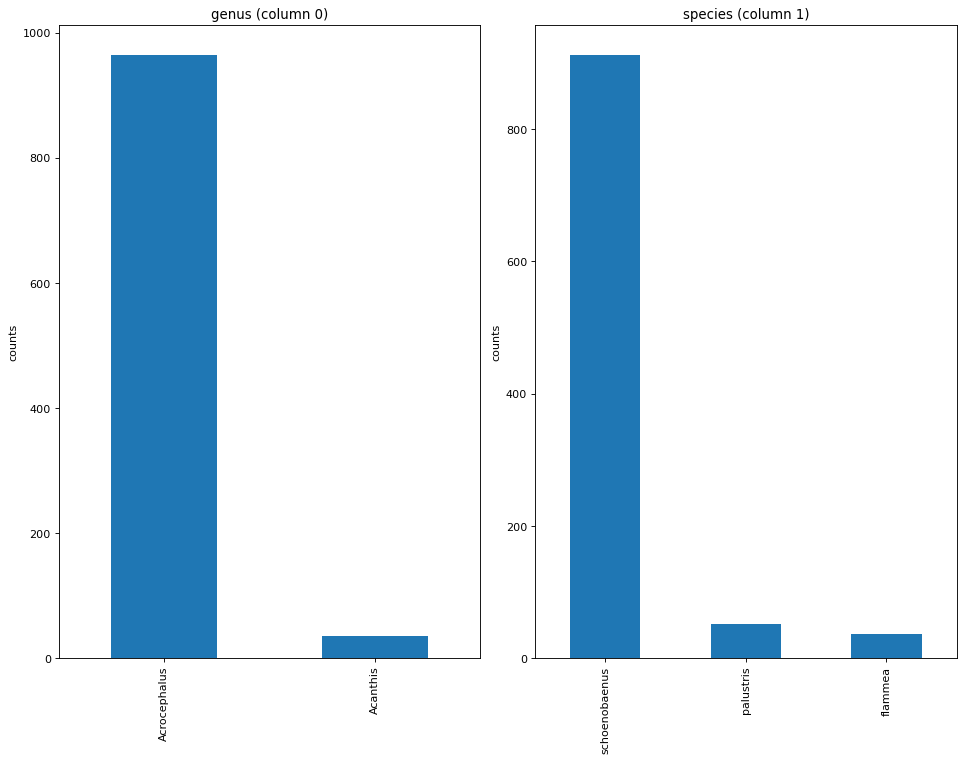

In [10]:
plotPerColumnDistribution(df1, 10, 5)

In [11]:
# Let's see how imbalanced we are
df1["genus"].value_counts(normalize=True).round(2)

Acrocephalus    0.96
Acanthis        0.04
Name: genus, dtype: float64

In [12]:
# Let's see how imbalanced we are
df1["species"].value_counts(normalize=True).round(2)

schoenobaenus    0.91
palustris        0.05
flammea          0.04
Name: species, dtype: float64

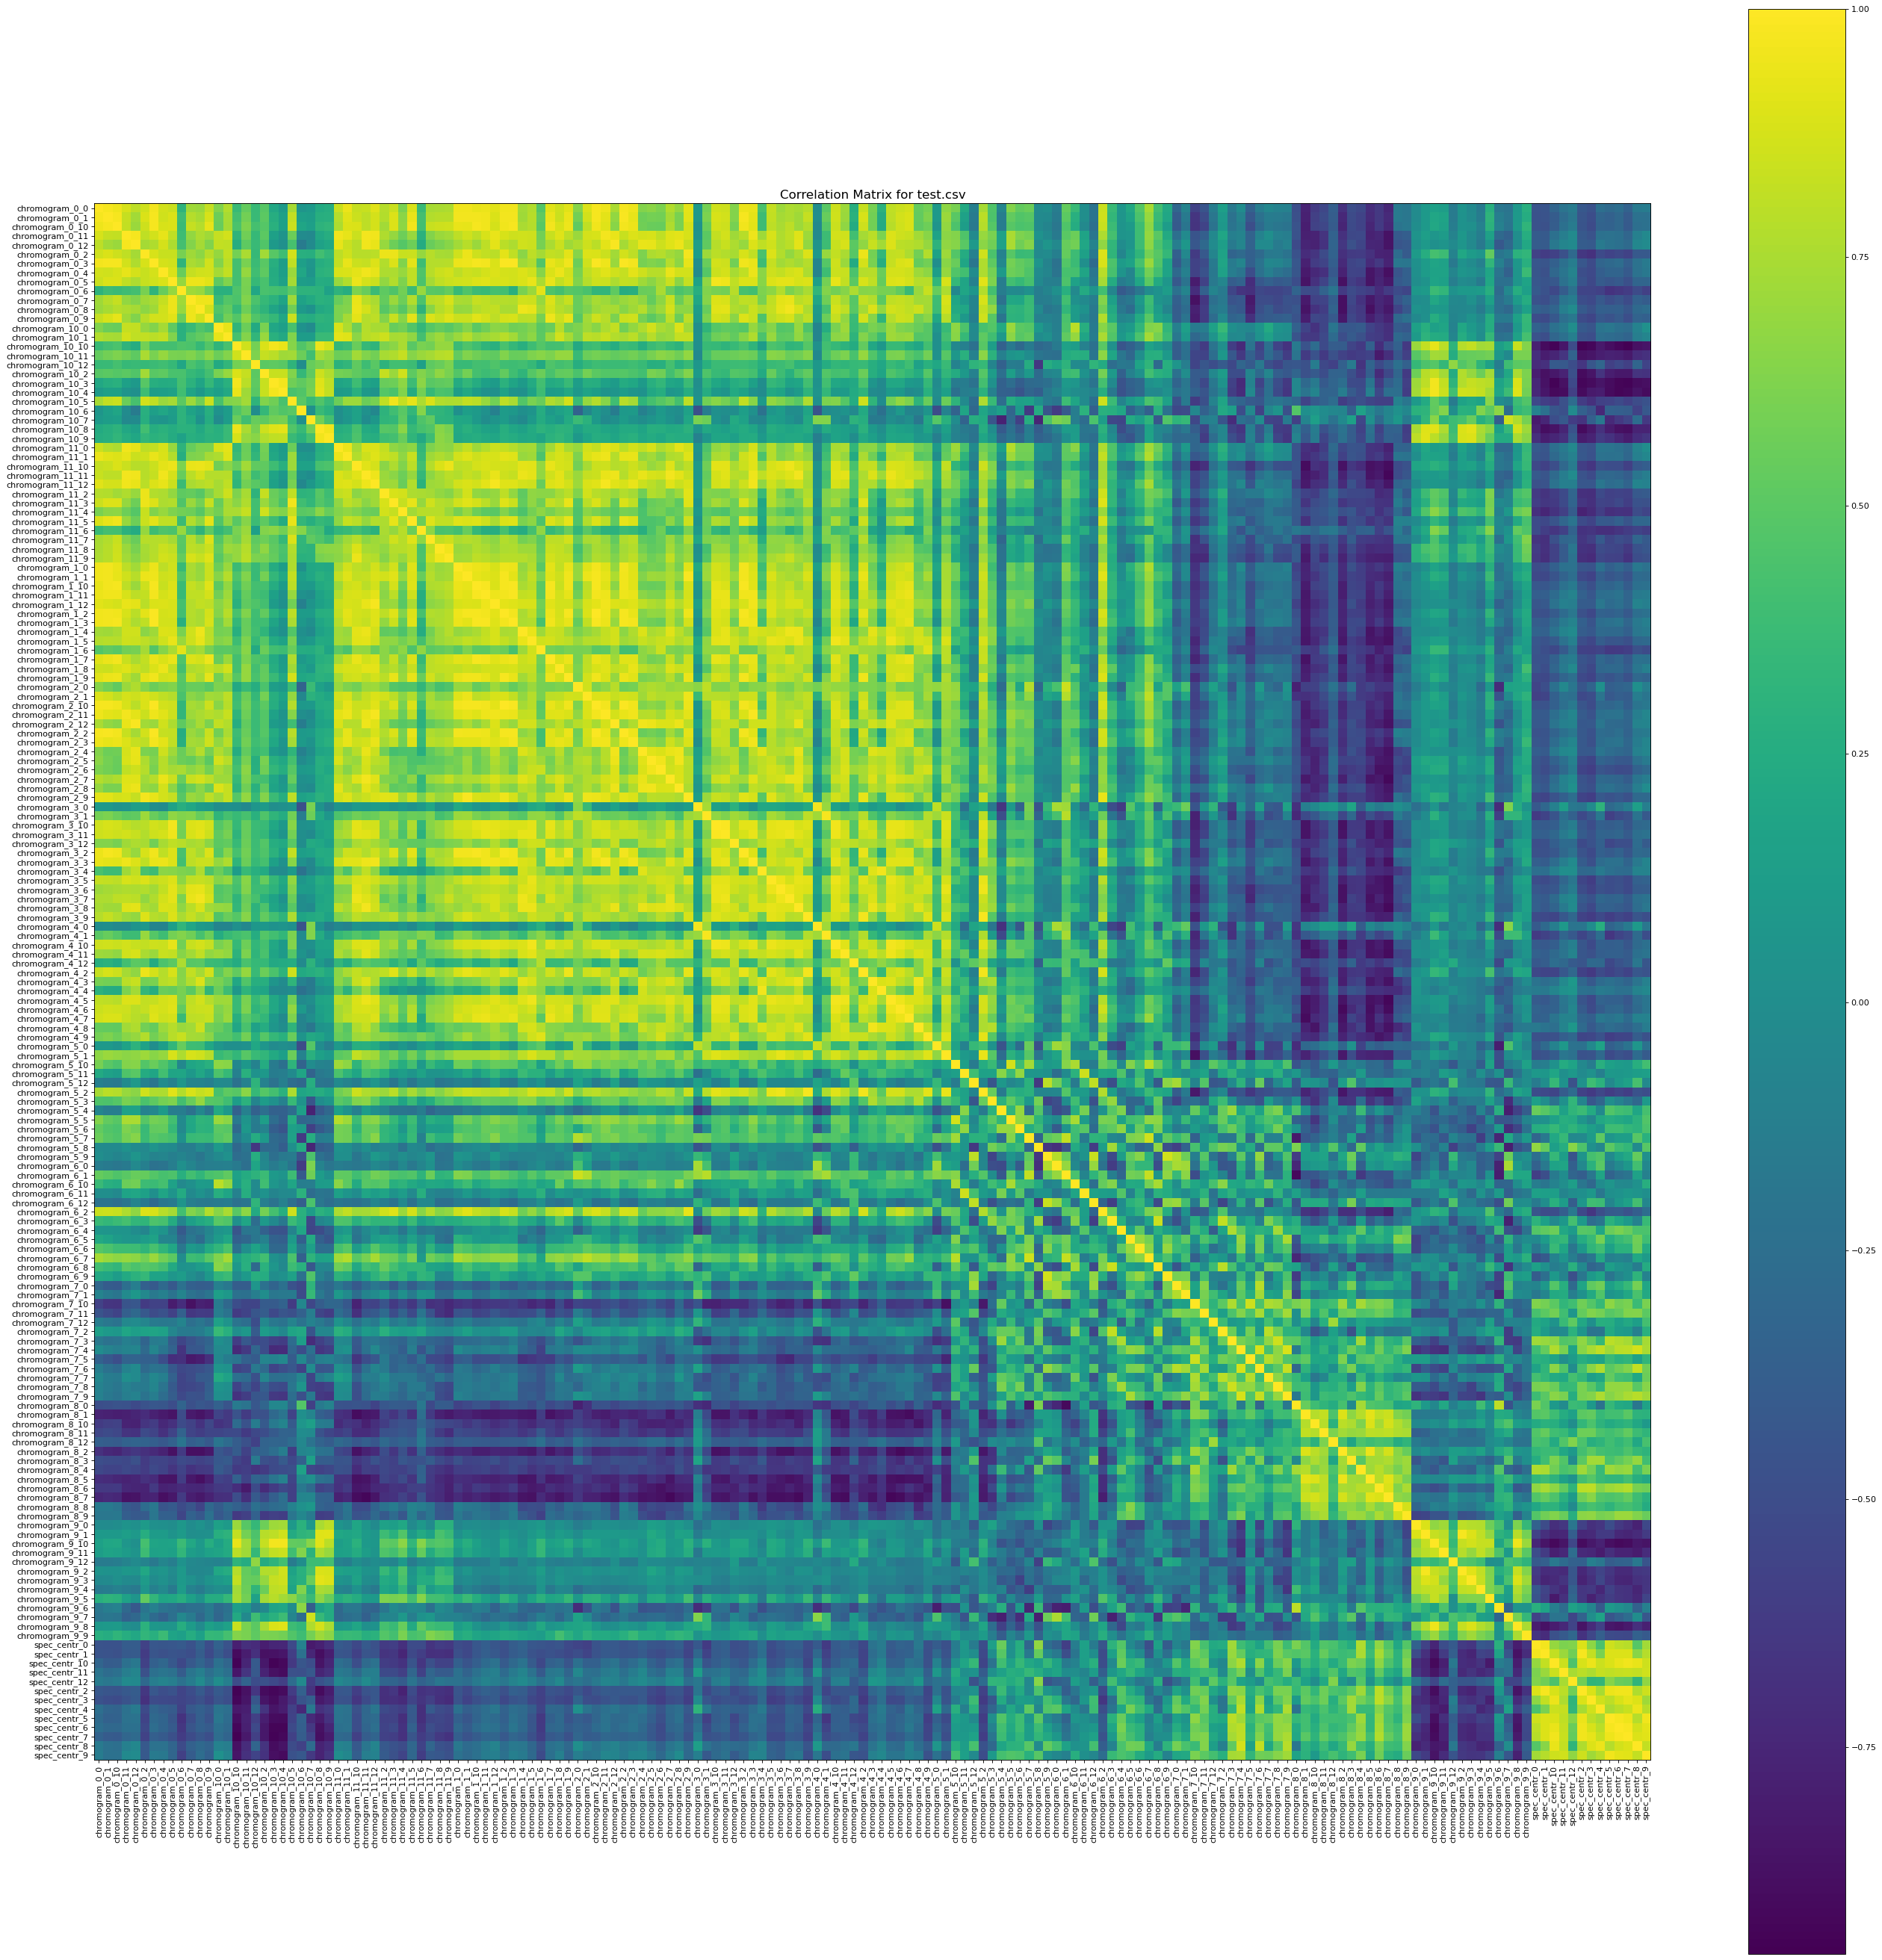

In [13]:
plotCorrelationMatrix(df1, 42)

In the upper left hand corner of this heat map, we see clear evidence of collinearity - we can expect to see the over-represented genii in these bands which is confirmed in the scatter plot below. 

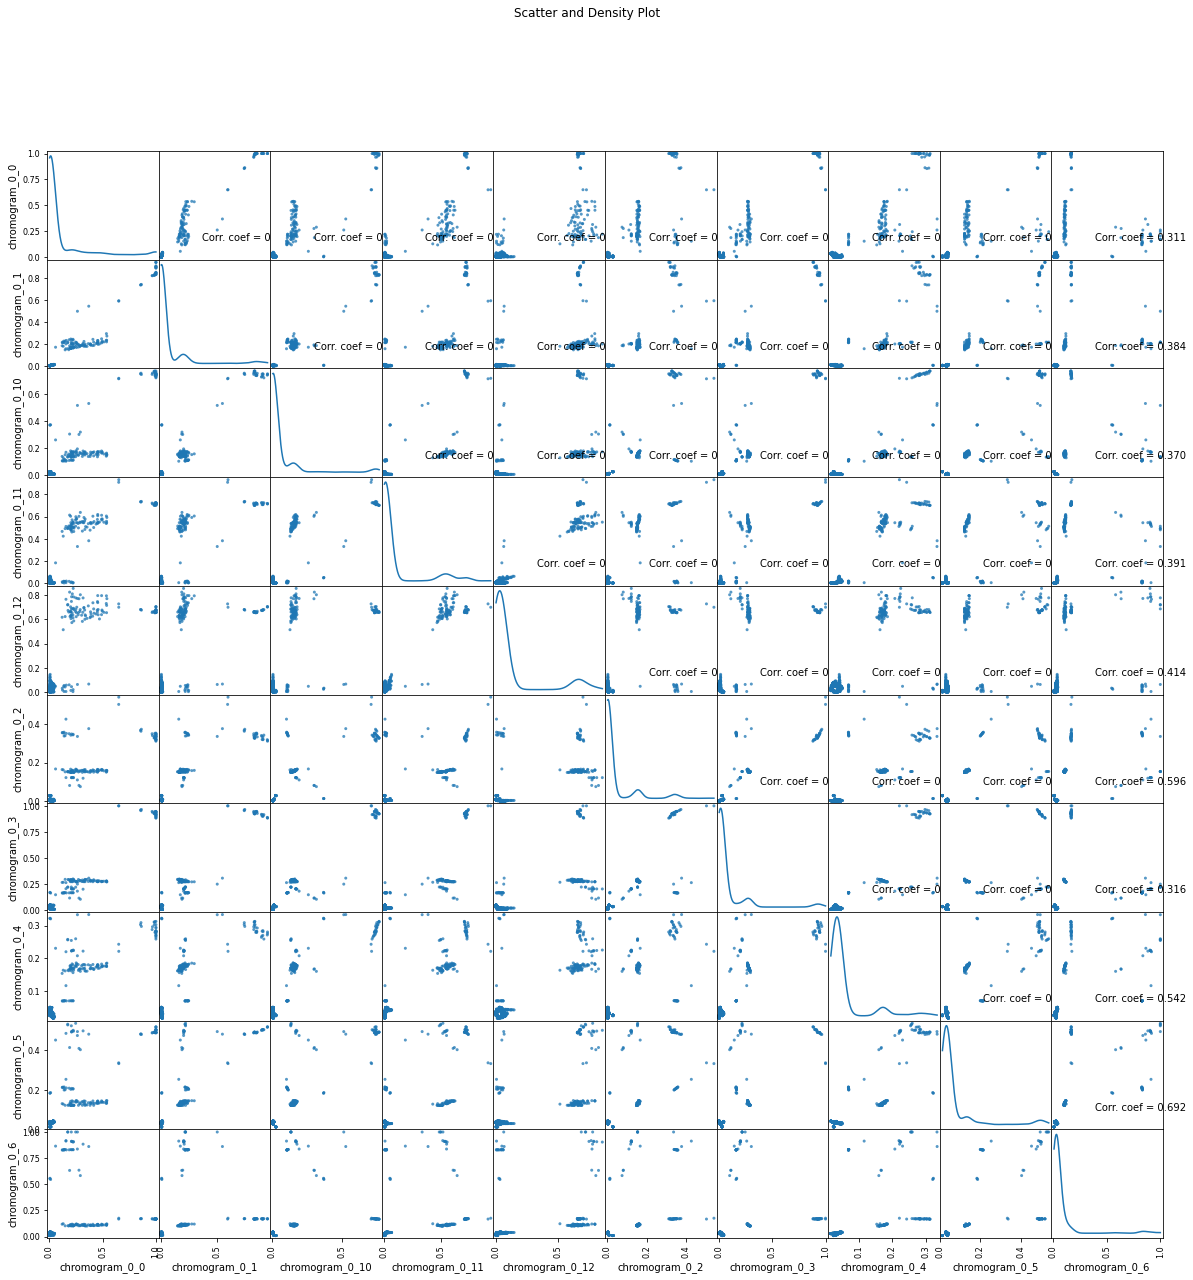

In [14]:
plotScatterMatrix(df1, 20, 10)

### The Train Data

In [15]:
# read in the train file set - toggle nRowsRead = 1000 for protoyping
nRowsRead = 1000 # specify 'None' if want to read whole file
df2 = pd.read_csv('./input/train.csv', delimiter=',', nrows = nRowsRead, index_col='id')
df2.dataframeName = 'train.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 171 columns


Let's take a quick look at what the data looks like: We see 156 chroma features, 12 spectral centroid reatures, choice of targets (genus, species) and an ID column

In [16]:
df2.head(5)

,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,chromogram_0_7,chromogram_0_8,chromogram_0_9,chromogram_10_0,chromogram_10_1,chromogram_10_10,chromogram_10_11,chromogram_10_12,chromogram_10_2,chromogram_10_3,chromogram_10_4,chromogram_10_5,chromogram_10_6,chromogram_10_7,chromogram_10_8,chromogram_10_9,chromogram_11_0,chromogram_11_1,chromogram_11_10,chromogram_11_11,chromogram_11_12,chromogram_11_2,chromogram_11_3,chromogram_11_4,chromogram_11_5,chromogram_11_6,chromogram_11_7,chromogram_11_8,chromogram_11_9,chromogram_1_0,chromogram_1_1,chromogram_1_10,chromogram_1_11,chromogram_1_12,chromogram_1_2,chromogram_1_3,chromogram_1_4,chromogram_1_5,chromogram_1_6,chromogram_1_7,chromogram_1_8,chromogram_1_9,chromogram_2_0,chromogram_2_1,chromogram_2_10,chromogram_2_11,chromogram_2_12,chromogram_2_2,chromogram_2_3,chromogram_2_4,chromogram_2_5,chromogram_2_6,chromogram_2_7,chromogram_2_8,chromogram_2_9,chromogram_3_0,chromogram_3_1,chromogram_3_10,chromogram_3_11,chromogram_3_12,chromogram_3_2,chromogram_3_3,chromogram_3_4,chromogram_3_5,chromogram_3_6,chromogram_3_7,chromogram_3_8,chromogram_3_9,chromogram_4_0,chromogram_4_1,chromogram_4_10,chromogram_4_11,chromogram_4_12,chromogram_4_2,chromogram_4_3,chromogram_4_4,chromogram_4_5,chromogram_4_6,chromogram_4_7,chromogram_4_8,chromogram_4_9,chromogram_5_0,chromogram_5_1,chromogram_5_10,chromogram_5_11,chromogram_5_12,chromogram_5_2,chromogram_5_3,chromogram_5_4,chromogram_5_5,chromogram_5_6,chromogram_5_7,chromogram_5_8,chromogram_5_9,chromogram_6_0,chromogram_6_1,chromogram_6_10,chromogram_6_11,chromogram_6_12,chromogram_6_2,chromogram_6_3,chromogram_6_4,chromogram_6_5,chromogram_6_6,chromogram_6_7,chromogram_6_8,chromogram_6_9,chromogram_7_0,chromogram_7_1,chromogram_7_10,chromogram_7_11,chromogram_7_12,chromogram_7_2,chromogram_7_3,chromogram_7_4,chromogram_7_5,chromogram_7_6,chromogram_7_7,chromogram_7_8,chromogram_7_9,chromogram_8_0,chromogram_8_1,chromogram_8_10,chromogram_8_11,chromogram_8_12,chromogram_8_2,chromogram_8_3,chromogram_8_4,chromogram_8_5,chromogram_8_6,chromogram_8_7,chromogram_8_8,chromogram_8_9,chromogram_9_0,chromogram_9_1,chromogram_9_10,chromogram_9_11,chromogram_9_12,chromogram_9_2,chromogram_9_3,chromogram_9_4,chromogram_9_5,chromogram_9_6,chromogram_9_7,chromogram_9_8,chromogram_9_9,genus,spec_centr_0,spec_centr_1,spec_centr_10,spec_centr_11,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.997944,0.832392,0.765386,0.704275,0.655724,0.331064,0.927524,0.307601,0.492226,0.167480,0.570316,0.384275,0.460739,0.405858,0.508725,0.377587,0.421529,0.555181,0.167464,0.229470,0.115128,0.863785,0.256774,0.204660,0.205049,0.236885,1.000000,1.0,0.768940,0.855763,1.0,0.281708,0.676977,0.246302,1.0,0.225182,0.421201,0.384887,0.459171,0.602492,0.505183,0.780623,0.959184,0.707844,0.581218,1.0,0.245248,0.332417,0.176712,0.550699,0.350335,0.493897,0.295650,0.305458,0.986670,1.0,0.547578,0.776386,0.862909,0.139677,0.243575,0.257196,0.544061,0.345198,0.695070,0.147905,0.237988,1.0,0.865009,0.378656,0.579663,0.505795,0.070084,0.461874,0.596447,0.706773,0.351387,0.738993,0.094750,0.346448,0.648426,0.510915,0.205902,0.579230,0.351208,0.041673,0.804871,0.954011,0.885739,0.352100,0.493117,0.097508,0.588290,0.408226,0.273142,0.090463,0.898724,0.470921,0.148026,0.815460,1.0,0.937467,0.461729,0.397452,0.067162,0.504283,0.222397,0.153017,0.037257,1.0,0.715027,0.847626,0.759205,0.870997,1.0,0.478178,0.325054,0.030570,0.242368,0.202561,0.178669,0.027788,0.654269,0.673528,1.0,0.574470,0.509623,0.577836,0.834410,0.749628,0.025663,0.097881,0.399511,0.434186,0.071515,0.224906,0.210857,0.211435,0.250697,0.424607,0.259147,1.0,1.0,0.066887

In [17]:
df2['genus'].value_counts().unique()

array([60, 40, 20], dtype=int64)

In [18]:
df2['genus'].unique()

array(['Acanthis', 'Acrocephalus', 'Aegithalos', 'Alauda', 'Anthus',
       'Apus', 'Branta', 'Calidris', 'Caprimulgus', 'Carduelis',
       'Certhia', 'Chloris', 'Chroicocephalus', 'Coloeus', 'Columba',
       'Corvus', 'Cuculus', 'Cyanistes', 'Delichon', 'Dendrocopos',
       'Dryocopus', 'Emberiza', 'Erithacus', 'Fringilla', 'Fulica',
       'Gallinago', 'Gallinula', 'Garrulus', 'Gavia', 'Haematopus',
       'Hirundo', 'Jynx', 'Lagopus', 'Larus', 'Linaria', 'Locustella',
       'Loxia', 'Luscinia', 'Merops', 'Motacilla'], dtype=object)

In [19]:
df2.info

<bound method DataFrame.info of      chromogram_0_0  chromogram_0_1  chromogram_0_10  chromogram_0_11  \
id                                                                      
0          0.997944        0.832392         0.765386         0.704275   
1          0.996255        0.839120         0.760417         0.705142   
2          0.970810        0.823540         0.759508         0.709058   
3          1.000000        0.855558         0.752038         0.710977   
4          1.000000        0.884305         0.741885         0.714775   
..              ...             ...              ...              ...   
995        0.006254        0.003738         0.000076         0.000110   
996        0.004317        0.003199         0.000076         0.000320   
997        0.007571        0.004166         0.000076         0.000557   
998        0.010599        0.004948         0.000076         0.000382   
999        0.007334        0.004014         0.000076         0.000123   

     chromogram_0_

In [20]:
df2.describe()

,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,chromogram_0_7,chromogram_0_8,chromogram_0_9,chromogram_10_0,chromogram_10_1,chromogram_10_10,chromogram_10_11,chromogram_10_12,chromogram_10_2,chromogram_10_3,chromogram_10_4,chromogram_10_5,chromogram_10_6,chromogram_10_7,chromogram_10_8,chromogram_10_9,chromogram_11_0,chromogram_11_1,chromogram_11_10,chromogram_11_11,chromogram_11_12,chromogram_11_2,chromogram_11_3,chromogram_11_4,chromogram_11_5,chromogram_11_6,chromogram_11_7,chromogram_11_8,chromogram_11_9,chromogram_1_0,chromogram_1_1,chromogram_1_10,chromogram_1_11,chromogram_1_12,chromogram_1_2,chromogram_1_3,chromogram_1_4,chromogram_1_5,chromogram_1_6,chromogram_1_7,chromogram_1_8,chromogram_1_9,chromogram_2_0,chromogram_2_1,chromogram_2_10,chromogram_2_11,chromogram_2_12,chromogram_2_2,chromogram_2_3,chromogram_2_4,chromogram_2_5,chromogram_2_6,chromogram_2_7,chromogram_2_8,chromogram_2_9,chromogram_3_0,chromogram_3_1,chromogram_3_10,chromogram_3_11,chromogram_3_12,chromogram_3_2,chromogram_3_3,chromogram_3_4,chromogram_3_5,chromogram_3_6,chromogram_3_7,chromogram_3_8,chromogram_3_9,chromogram_4_0,chromogram_4_1,chromogram_4_10,chromogram_4_11,chromogram_4_12,chromogram_4_2,chromogram_4_3,chromogram_4_4,chromogram_4_5,chromogram_4_6,chromogram_4_7,chromogram_4_8,chromogram_4_9,chromogram_5_0,chromogram_5_1,chromogram_5_10,chromogram_5_11,chromogram_5_12,chromogram_5_2,chromogram_5_3,chromogram_5_4,chromogram_5_5,chromogram_5_6,chromogram_5_7,chromogram_5_8,chromogram_5_9,chromogram_6_0,chromogram_6_1,chromogram_6_10,chromogram_6_11,chromogram_6_12,chromogram_6_2,chromogram_6_3,chromogram_6_4,chromogram_6_5,chromogram_6_6,chromogram_6_7,chromogram_6_8,chromogram_6_9,chromogram_7_0,chromogram_7_1,chromogram_7_10,chromogram_7_11,chromogram_7_12,chromogram_7_2,chromogram_7_3,chromogram_7_4,chromogram_7_5,chromogram_7_6,chromogram_7_7,chromogram_7_8,chromogram_7_9,chromogram_8_0,chromogram_8_1,chromogram_8_10,chromogram_8_11,chromogram_8_12,chromogram_8_2,chromogram_8_3,chromogram_8_4,chromogram_8_5,chromogram_8_6,chromogram_8_7,chromogram_8_8,chromogram_8_9,chromogram_9_0,chromogram_9_1,chromogram_9_10,chromogram_9_11,chromogram_9_12,chromogram_9_2,chromogram_9_3,chromogram_9_4,chromogram_9_5,chromogram_9_6,chromogram_9_7,chromogram_9_8,chromogram_9_9,spec_centr_0,spec_centr_1,spec_centr_10,spec_centr_11,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.00

In [21]:
# check for duplicates
df2.duplicated()

id
0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [22]:
# The question is: Are there nulls in any of features? 
null_df = pd.DataFrame(df2.isna().sum() > 0)
null_df.value_counts()

False    171
dtype: int64

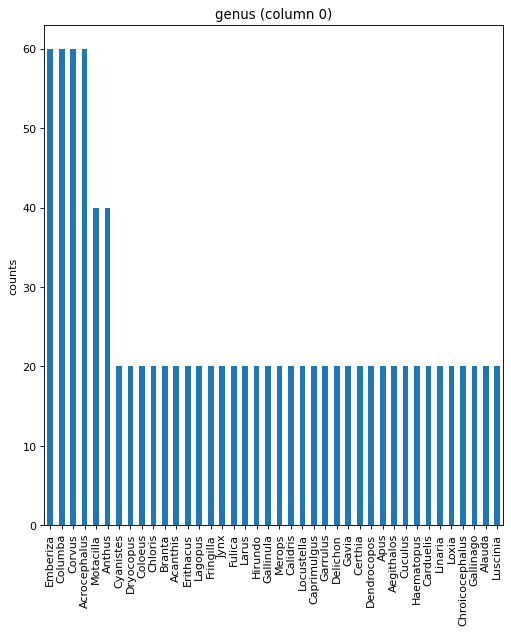

In [23]:
plotPerColumnDistribution(df2, 10, 5)

We can see that there are a few classes with higher counts, but overall the train set is pretty balanced.
We note corvus genus as _the_ dominant class along the warblers (Acrocephalus), pigeons (columba), buntings (Emberiza). In the middle we have the wagtails (Motacilla), and the pipits(Anthus). All the other species are balanced.

In [24]:
# while the genus is slightly unbalanced, the species are equally distributed.
df2["species"].value_counts(normalize=True).round(2)

calandra         0.02
schoeniclus      0.02
flava            0.02
atra             0.02
carduelis        0.02
apiaster         0.02
torquilla        0.02
rustica          0.02
familiaris       0.02
caudatus         0.02
ostralegus       0.02
urbicum          0.02
scirpaceus       0.02
ridibundus       0.02
gallinago        0.02
trivialis        0.02
frugilegus       0.02
canadensis       0.02
monedula         0.02
flammea          0.02
lagopus          0.02
schoenobaenus    0.02
europaeus        0.02
palustris        0.02
glandarius       0.02
oenas            0.02
curvirostra      0.02
rubecula         0.02
canorus          0.02
corone           0.02
major            0.02
palumbus         0.02
stellata         0.02
cannabina        0.02
caeruleus        0.02
arvensis         0.02
chloropus        0.02
alpina           0.02
citrinella       0.02
martius          0.02
chloris          0.02
apus             0.02
pratensis        0.02
aguimp           0.02
coelebs          0.02
livia     

In [25]:
#listing all the genii

df2["genus"].unique()

array(['Acanthis', 'Acrocephalus', 'Aegithalos', 'Alauda', 'Anthus',
       'Apus', 'Branta', 'Calidris', 'Caprimulgus', 'Carduelis',
       'Certhia', 'Chloris', 'Chroicocephalus', 'Coloeus', 'Columba',
       'Corvus', 'Cuculus', 'Cyanistes', 'Delichon', 'Dendrocopos',
       'Dryocopus', 'Emberiza', 'Erithacus', 'Fringilla', 'Fulica',
       'Gallinago', 'Gallinula', 'Garrulus', 'Gavia', 'Haematopus',
       'Hirundo', 'Jynx', 'Lagopus', 'Larus', 'Linaria', 'Locustella',
       'Loxia', 'Luscinia', 'Merops', 'Motacilla'], dtype=object)

The train set is in pretty good shape - a few classes with higher frequency, but over all fairly balanced

Correlation matrix:

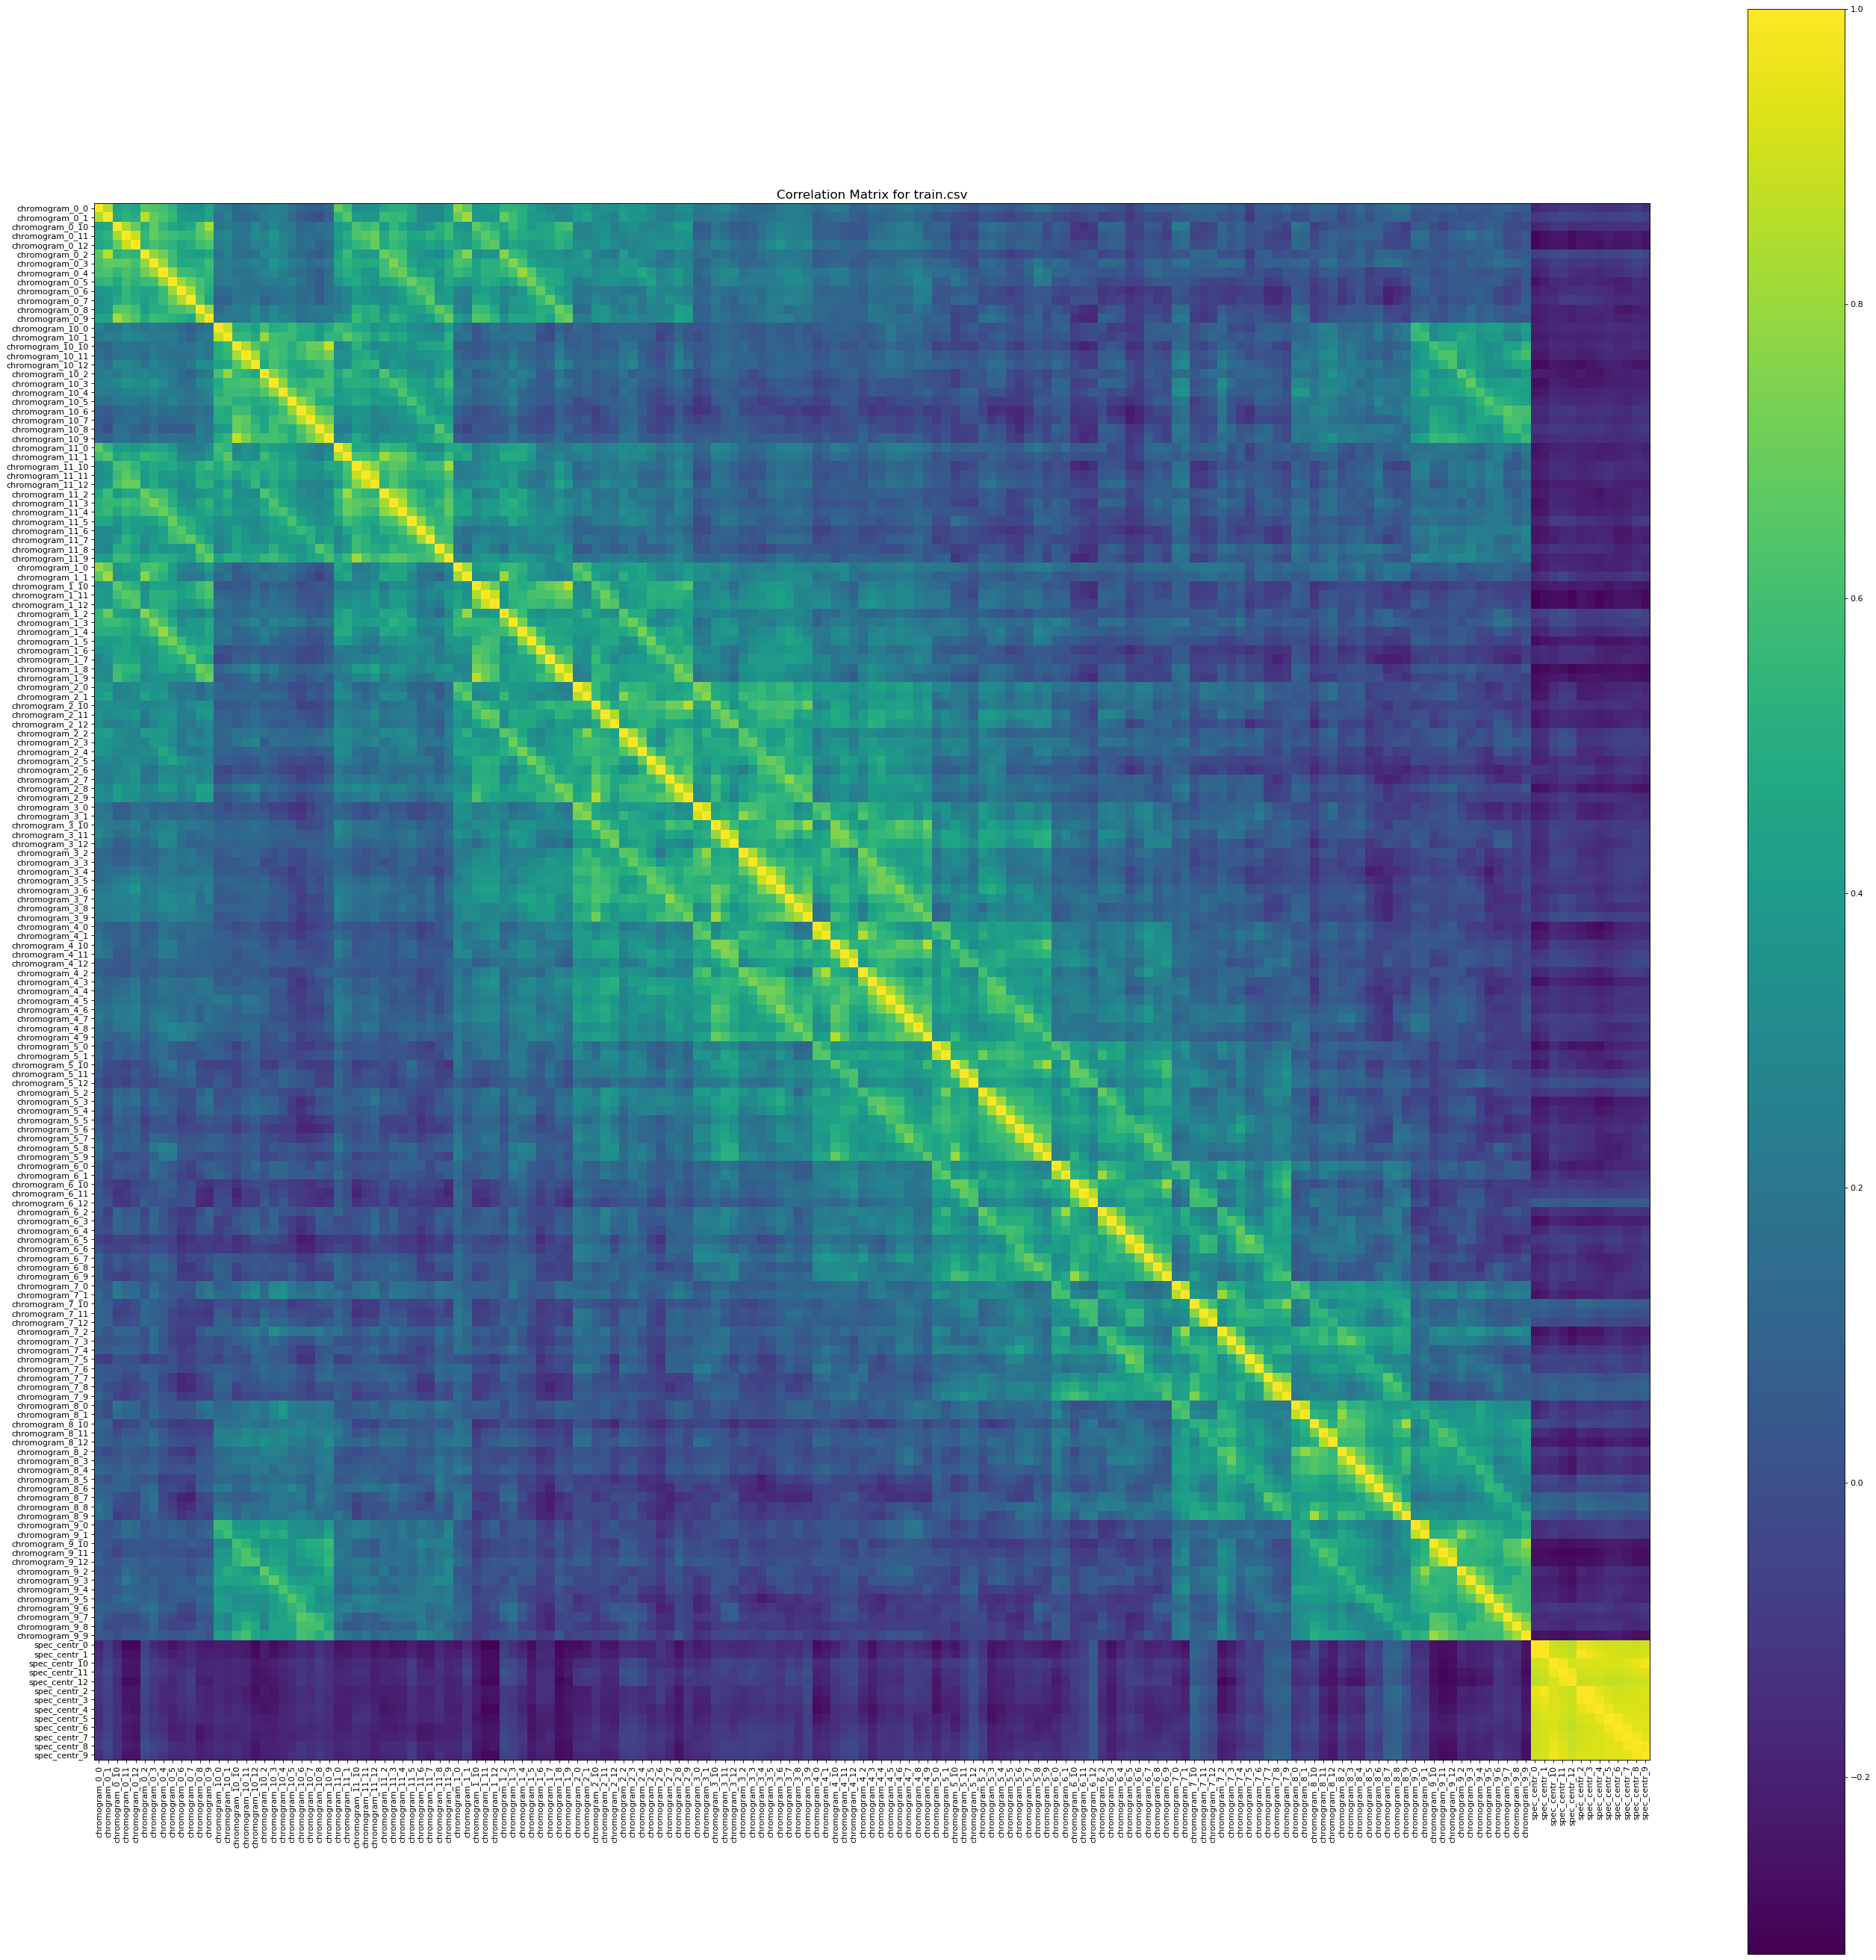

In [26]:
plotCorrelationMatrix(df2, 42)

Scatter plot of the train set. 

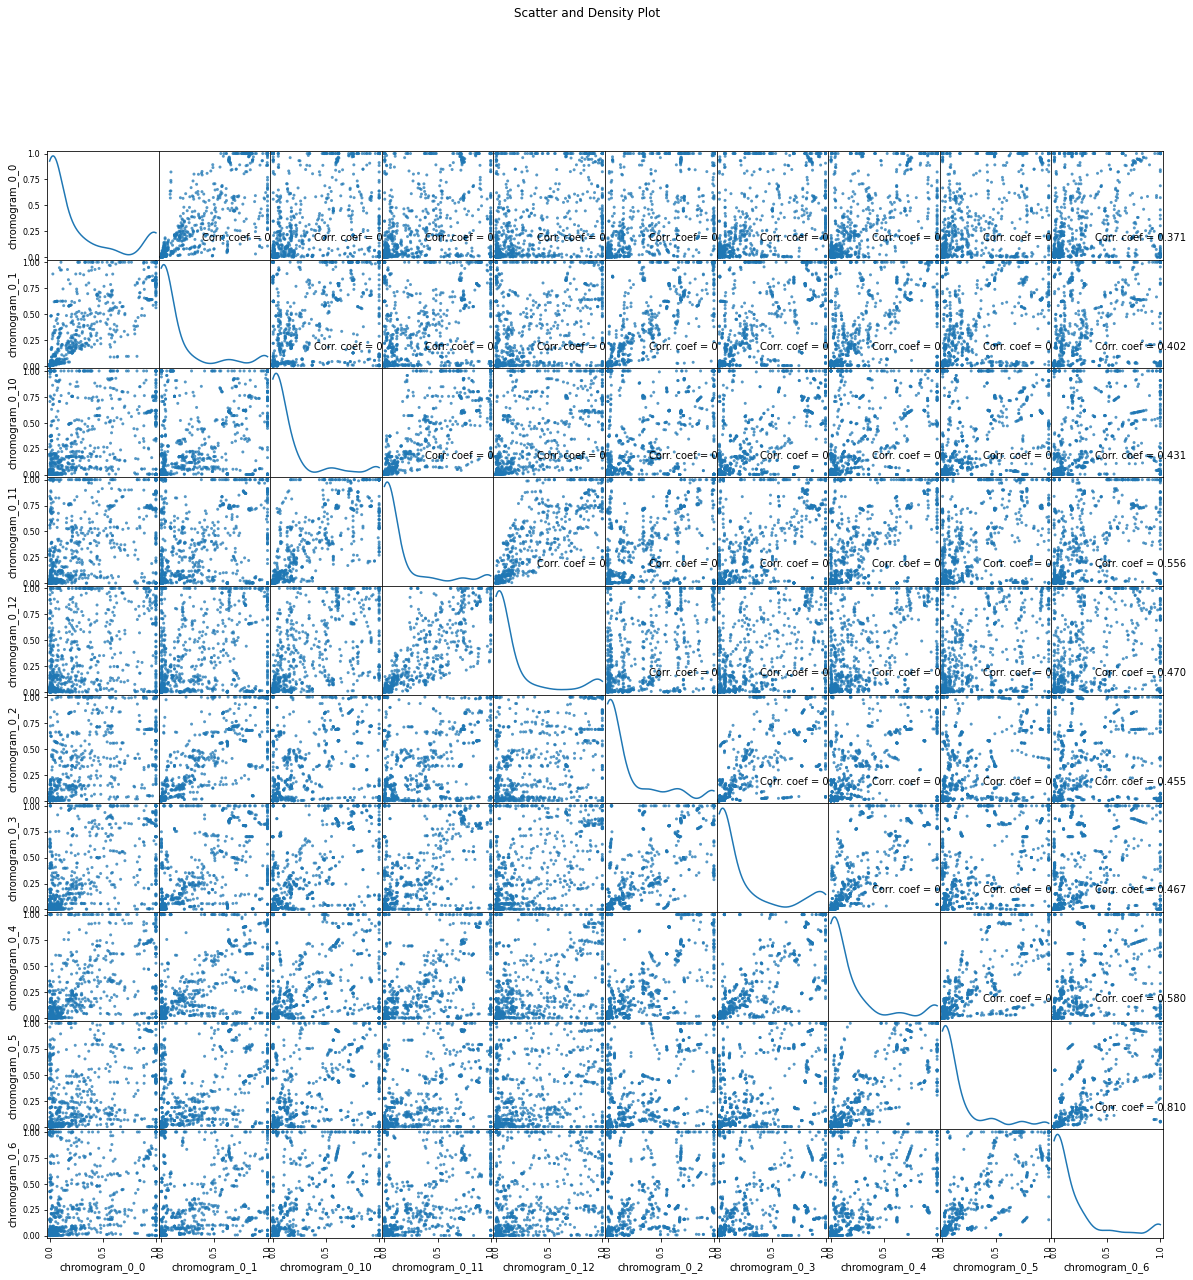

In [27]:
plotScatterMatrix(df2, 20, 10)

While we can see some tell-tale arrow shapes, the over all randomness of the train set not too pronounced.

## Benchmarking

We will do some out of the box benchmarking to predict genus assuming that all members of a species will share similar song structural characteristics, though the frequency may shift among species. 

### HistGradientBoostingClassifier 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

# HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
model = HistGradientBoostingClassifier(random_state=42)
cv_results = cross_validate(model, X, y, scoring="balanced_accuracy", 
                            return_train_score=True, 
                            return_estimator=True,n_jobs=-1)
print(f"Balanced accuracy mean +/- std. dev.: "
      f"{cv_results['test_score'].mean():.3f} +/- "
      f"{cv_results['test_score'].std():.3f}"     )
      

Balanced accuracy mean +/- std. dev.: 0.847 +/- 0.108


In [29]:
from sklearn.metrics import balanced_accuracy_score
scores = []
for fold_id, cv_model in enumerate(cv_results["estimator"]):
    scores.append(
        balanced_accuracy_score(
            y_val, cv_model.predict(X_val)))
print(f"Balanced accuracy mean +/- std. dev.: "
      f"{np.mean(scores):.3f} +/- {np.std(scores):.3f}")

       

Balanced accuracy mean +/- std. dev.: 0.968 +/- 0.023


In [30]:

# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

from imblearn.under_sampling import RandomUnderSampler
# setting up a pipeline 
from imblearn.pipeline import make_pipeline
model = make_pipeline(
    RandomUnderSampler(random_state=42),
    HistGradientBoostingClassifier(random_state=42))
cv_results = cross_validate(
    model, X, y, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True,
    n_jobs=-1)
print(
    f"Balanced accuracy mean +/- std. dev.: "
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}")   
    

Balanced accuracy mean +/- std. dev.: 0.819 +/- 0.110


In [31]:
from sklearn.metrics import balanced_accuracy_score
scores = []
for fold_id, cv_model in enumerate(cv_results["estimator"]):
    scores.append(
        balanced_accuracy_score(
            y_val, cv_model.predict(X_val)))
print(f"Balanced accuracy mean +/- std. dev.: "
      f"{np.mean(scores):.3f} +/- {np.std(scores):.3f}")


Balanced accuracy mean +/- std. dev.: 0.950 +/- 0.027


### Logistic Regression Out of the Box

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# setup data and target
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

val_scores = []
train_scores = []
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    # initialize with current c value
    my_logreg = LogisticRegression(C = c, random_state=1)
    
    # fit the model on train
    my_logreg.fit(X_train, y_train)
    
    # score on traning set
    train_scores.append(my_logreg.score(X_train, y_train))
    
    # score on val set
    val_scores.append(my_logreg.score(X_val, y_val))
    

In [33]:
train_scores

[0.08666666666666667,
 0.192,
 0.4066666666666667,
 0.5706666666666667,
 0.5746666666666667,
 0.592,
 0.5506666666666666,
 0.5893333333333334,
 0.596,
 0.6026666666666667,
 0.6026666666666667,
 0.604,
 0.604,
 0.604,
 0.604,
 0.604,
 0.604]

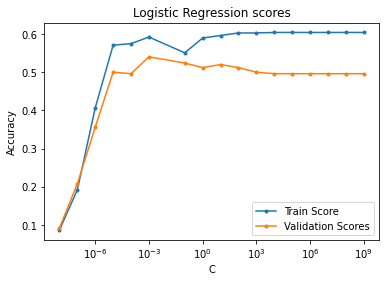

In [34]:
# Plot the validation scores
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, val_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Logistic Regression scores')
plt.legend()
plt.show();

Looking at the graph above, we can see we have the best results around $ C=-10 

### Logistic Regression with Cross Validation

In [35]:
from sklearn.linear_model import LogisticRegressionCV
# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)


val_scores = []
train_scores = []
C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])
for c in C_range:

    clf = LogisticRegressionCV(cv=5, class_weight='balanced', multi_class='ovr', random_state=42).fit(X_train, y_train)
    clf.predict(X.iloc[:2, :])

    clf.predict_proba(X.iloc[:2, :]).shape

    clf.score(X_val, y_val)
    # score on traning set
    train_scores.append(my_logreg.score(X_train, y_train))
    
    # score on val set
    val_scores.append(my_logreg.score(X_val, y_val))
    
    


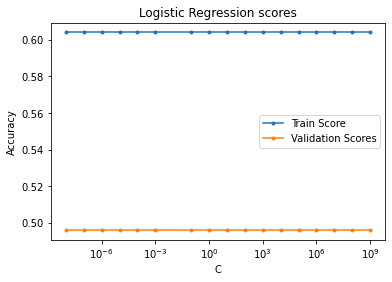

In [36]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, val_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Logistic Regression scores')
plt.legend()
plt.show();

### Pipeline PCA and LogisticRegressionCV

In [37]:
## Model1

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline


pca = PCA(random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
clf = LogisticRegressionCV(cv=5, class_weight='balanced', multi_class='ovr', random_state=42)

model1 = make_pipeline(pca, clf)
## x_train, y_train

# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

from sklearn.metrics import classification_report

model1.fit(X_train, y_train)
y_pred = model1.predict(X_val)
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

       Acanthis       1.00      1.00      1.00         5
   Acrocephalus       1.00      0.80      0.89        15
     Aegithalos       1.00      1.00      1.00         5
         Alauda       1.00      0.80      0.89         5
         Anthus       0.89      0.80      0.84        10
           Apus       0.83      1.00      0.91         5
         Branta       0.83      1.00      0.91         5
       Calidris       0.67      0.80      0.73         5
    Caprimulgus       1.00      1.00      1.00         5
      Carduelis       1.00      1.00      1.00         5
        Certhia       0.83      1.00      0.91         5
        Chloris       1.00      1.00      1.00         5
Chroicocephalus       1.00      1.00      1.00         5
        Coloeus       1.00      1.00      1.00         5
        Columba       0.94      1.00      0.97        15
         Corvus       1.00      0.67      0.80        15
        Cuculus       0.83    

Here we see the model has the most trouble identifying: Calidris(Dunlin), Linaria(Common Linnet) and Gavia(Loon). What is it about these images that are confusing to the model? 

In [38]:
print(pca.explained_variance_ratio_)

[9.33045578e-01 2.31439778e-02 1.58972655e-02 9.09904540e-03
 7.21711200e-03 4.16000333e-03 2.81745337e-03 2.36825129e-03
 1.19559043e-03 5.01030972e-04 2.52377922e-04 1.66134238e-04
 1.34429035e-04 2.84435847e-07 2.62140745e-07 2.18246190e-07
 1.06974948e-07 7.10237679e-08 5.58075379e-08 4.88012862e-08
 4.56861958e-08 4.07283405e-08 3.43735758e-08 3.19745207e-08
 3.02395084e-08 2.74594680e-08 2.67639851e-08 2.34553516e-08
 2.09687288e-08 2.05976117e-08 1.93607408e-08 1.79498264e-08
 1.64690696e-08 1.59282272e-08 1.53131192e-08 1.46226383e-08
 1.40368502e-08 1.33755126e-08 1.24402292e-08 1.20781395e-08
 1.11135790e-08 1.08828756e-08 1.04928791e-08 9.71783273e-09
 9.24268809e-09 8.42740446e-09 8.26347943e-09 7.94803897e-09
 7.48095376e-09 6.76121957e-09 6.58055329e-09 6.39529870e-09
 6.19324806e-09 5.76585988e-09 5.55624447e-09 5.38347434e-09
 5.17599672e-09 5.10276871e-09 4.81223172e-09 4.59971497e-09
 4.40329832e-09 4.16998794e-09 3.97504733e-09 3.60108412e-09
 3.55822463e-09 3.522510

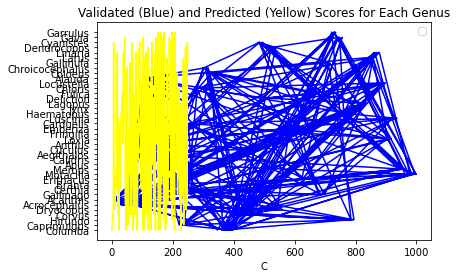

In [39]:
plt.figure()
plt.plot(y_val, c='blue')
plt.plot(y_pred, c='yellow')
plt.xlabel('C')
plt.title('Validated (Blue) and Predicted (Yellow) Scores for Each Genus')
plt.legend('Validated ', 'Predicted ')
plt.show()

The shape of the scores is quite different between the validated and predicted scores.


### Pipeline Model 2: PCA, ENN, SMOTE and KNN

In [40]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

pca = PCA(random_state=42)
enn = EditedNearestNeighbours()
smote = SMOTE(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)

model2 = make_pipeline(pca, enn, smote, knn)

# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)



model2.fit(X_train, y_train)
y_pred = model2.predict(X_val)
print(classification_report(y_val, y_pred))



                 precision    recall  f1-score   support

       Acanthis       0.62      1.00      0.77         5
   Acrocephalus       0.79      1.00      0.88        15
     Aegithalos       1.00      1.00      1.00         5
         Alauda       1.00      0.40      0.57         5
         Anthus       1.00      0.50      0.67        10
           Apus       0.50      0.80      0.62         5
         Branta       1.00      1.00      1.00         5
       Calidris       0.80      0.80      0.80         5
    Caprimulgus       1.00      0.40      0.57         5
      Carduelis       1.00      0.80      0.89         5
        Certhia       1.00      0.60      0.75         5
        Chloris       0.50      1.00      0.67         5
Chroicocephalus       0.71      1.00      0.83         5
        Coloeus       0.83      1.00      0.91         5
        Columba       0.88      0.93      0.90        15
         Corvus       0.73      0.73      0.73        15
        Cuculus       0.62    

This particular model is not particularly good - at not better than 50-50 with many of the class.

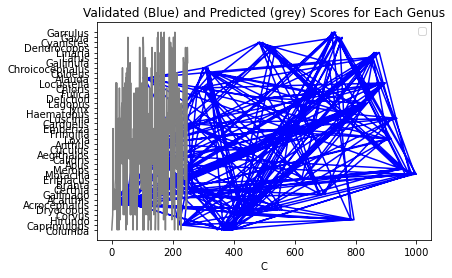

In [41]:
plt.figure()
plt.plot(y_val, c='blue')
plt.plot(y_pred, c='grey')
plt.xlabel('C')
plt.title('Validated (Blue) and Predicted (grey) Scores for Each Genus')
plt.legend('Validated ', 'Predicted ')
plt.show()

Confusion matrix, without normalization
[[ 5  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 1  0  0 ...  0  0  9]]
Normalized confusion matrix
[[1.  0.  0.  ... 0.  0.  0. ]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.1 0.  0.  ... 0.  0.  0.9]]


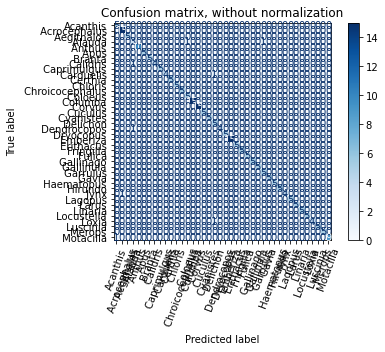

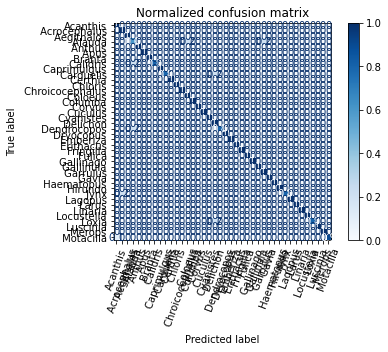

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']
class_names = ['Acanthis',
' Acrocephalus',
' Aegithalos',
' Alauda',
' Anthus',
' Apus',
' Branta',
' Calidris',
' Caprimulgus',
' Carduelis',
' Certhia',
' Chloris',
' Chroicocephalus',
' Coloeus',
' Columba',
' Corvus',
' Cuculus',
' Cyanistes',
' Delichon',
' Dendrocopos',
' Dryocopus',
' Emberiza',
' Erithacus',
' Fringilla',
' Fulica',
' Gallinago',
' Gallinula',
' Garrulus',
' Gavia',
' Haematopus',
' Hirundo',
' Jynx',
' Lagopus',
' Larus',
' Linaria',
' Locustella',
' Loxia',
' Luscinia',
' Merops',
' Motacilla'
]

# Split the data into a training set and a test set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_val, y_val,
                                 display_labels=class_names,
                                 xticks_rotation= 70,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Bagging Classifier with Decision Tree

In [43]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                       random_state=0)

# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

bc.fit(X_train, y_train) 

y_pred = bc.predict(X_val)
balanced_accuracy_score(y_val, y_pred) 
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

       Acanthis       0.83      1.00      0.91         5
   Acrocephalus       1.00      1.00      1.00        15
     Aegithalos       1.00      1.00      1.00         5
         Alauda       0.67      0.80      0.73         5
         Anthus       0.83      1.00      0.91        10
           Apus       1.00      1.00      1.00         5
         Branta       1.00      1.00      1.00         5
       Calidris       1.00      0.80      0.89         5
    Caprimulgus       1.00      1.00      1.00         5
      Carduelis       1.00      0.80      0.89         5
        Certhia       1.00      1.00      1.00         5
        Chloris       1.00      1.00      1.00         5
Chroicocephalus       1.00      1.00      1.00         5
        Coloeus       1.00      1.00      1.00         5
        Columba       0.94      1.00      0.97        15
         Corvus       0.88      0.93      0.90        15
        Cuculus       1.00    

The Bagging Classlifier with Decision Tree had the most trouble with the genus Alauda.

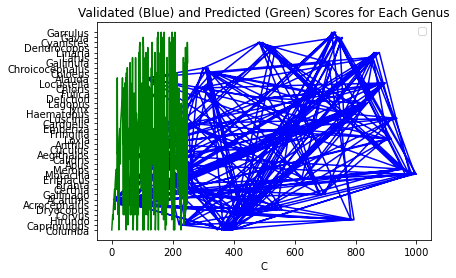

In [44]:
plt.figure()
plt.plot(y_val, c='blue')
plt.plot(y_pred, c='green')
plt.xlabel('C')
plt.title('Validated (Blue) and Predicted (Green) Scores for Each Genus')
plt.legend('Validated ', 'Predicted ')
plt.show()

### Balanced Bagging Classifier using Decision Tree

In [45]:
from imblearn.ensemble import BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)

# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)


bbc.fit(X_train, y_train) 

y_pred = bbc.predict(X_val)
balanced_accuracy_score(y_val, y_pred)
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

       Acanthis       0.71      1.00      0.83         5
   Acrocephalus       1.00      0.87      0.93        15
     Aegithalos       1.00      1.00      1.00         5
         Alauda       1.00      1.00      1.00         5
         Anthus       0.91      1.00      0.95        10
           Apus       1.00      1.00      1.00         5
         Branta       1.00      1.00      1.00         5
       Calidris       1.00      0.80      0.89         5
    Caprimulgus       1.00      1.00      1.00         5
      Carduelis       0.67      0.80      0.73         5
        Certhia       1.00      1.00      1.00         5
        Chloris       1.00      1.00      1.00         5
Chroicocephalus       1.00      1.00      1.00         5
        Coloeus       1.00      1.00      1.00         5
        Columba       1.00      0.93      0.97        15
         Corvus       1.00      0.80      0.89        15
        Cuculus       0.45    

### Ensemble Balanced Random Forest Classifier

In [46]:
# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train) 

y_pred = brf.predict(X_val)
balanced_accuracy_score(y_val, y_pred)  
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

       Acanthis       1.00      1.00      1.00         5
   Acrocephalus       1.00      1.00      1.00        15
     Aegithalos       1.00      1.00      1.00         5
         Alauda       0.80      0.80      0.80         5
         Anthus       1.00      1.00      1.00        10
           Apus       1.00      1.00      1.00         5
         Branta       1.00      1.00      1.00         5
       Calidris       1.00      0.80      0.89         5
    Caprimulgus       1.00      1.00      1.00         5
      Carduelis       0.80      0.80      0.80         5
        Certhia       1.00      1.00      1.00         5
        Chloris       1.00      1.00      1.00         5
Chroicocephalus       1.00      1.00      1.00         5
        Coloeus       1.00      1.00      1.00         5
        Columba       1.00      1.00      1.00        15
         Corvus       1.00      1.00      1.00        15
        Cuculus       1.00    

Great Results! Here we see the model correctly identified nearly all the genus except for the following: Aluada, Carduelis, Erithacus, and Merops. What is different about these particular bird samples?  

### RUSBoost Classifier

In [49]:
# fresh train data
X = df2.drop(columns=['genus', 'species'])
y = df2['genus']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

## RUSBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=100, algorithm='SAMME.R',
                              random_state=42)
rusboost.fit(X_train, y_train)  

y_pred = rusboost.predict(X_val)
balanced_accuracy_score(y_val, y_pred) 
print(classification_report(y_val, y_pred))


                 precision    recall  f1-score   support

       Acanthis       1.00      0.60      0.75         5
   Acrocephalus       0.00      0.00      0.00        15
     Aegithalos       0.00      0.00      0.00         5
         Alauda       0.14      0.40      0.21         5
         Anthus       0.50      0.40      0.44        10
           Apus       0.36      0.80      0.50         5
         Branta       0.00      0.00      0.00         5
       Calidris       0.00      0.00      0.00         5
    Caprimulgus       0.45      1.00      0.62         5
      Carduelis       0.00      0.00      0.00         5
        Certhia       0.75      0.60      0.67         5
        Chloris       0.00      0.00      0.00         5
Chroicocephalus       0.00      0.00      0.00         5
        Coloeus       0.00      0.00      0.00         5
        Columba       0.71      0.33      0.45        15
         Corvus       0.39      0.47      0.42        15
        Cuculus       1.00    

Wow. That score is really bad, worst yet.  

### Pipeline Model using PCA, SMOTE and KNN

In [50]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

X = df2.drop(columns=['genus', 'species'])
y = df2['genus']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

print('Original dataset shape {}'.format(Counter(y)))
pca = PCA()
smt = SMOTE(random_state=42)
knn = KNN()
pipeline = Pipeline([('smt', smt), ('pca', pca), ('knn', knn)])

pipeline.fit(X_train, y_train) 
y_hat = pipeline.predict(X_val)
print(classification_report(y_val, y_hat))


Original dataset shape Counter({'Acrocephalus': 60, 'Columba': 60, 'Corvus': 60, 'Emberiza': 60, 'Anthus': 40, 'Motacilla': 40, 'Acanthis': 20, 'Aegithalos': 20, 'Alauda': 20, 'Apus': 20, 'Branta': 20, 'Calidris': 20, 'Caprimulgus': 20, 'Carduelis': 20, 'Certhia': 20, 'Chloris': 20, 'Chroicocephalus': 20, 'Coloeus': 20, 'Cuculus': 20, 'Cyanistes': 20, 'Delichon': 20, 'Dendrocopos': 20, 'Dryocopus': 20, 'Erithacus': 20, 'Fringilla': 20, 'Fulica': 20, 'Gallinago': 20, 'Gallinula': 20, 'Garrulus': 20, 'Gavia': 20, 'Haematopus': 20, 'Hirundo': 20, 'Jynx': 20, 'Lagopus': 20, 'Larus': 20, 'Linaria': 20, 'Locustella': 20, 'Loxia': 20, 'Luscinia': 20, 'Merops': 20})
                 precision    recall  f1-score   support

       Acanthis       0.71      1.00      0.83         5
   Acrocephalus       0.94      1.00      0.97        15
     Aegithalos       1.00      1.00      1.00         5
         Alauda       1.00      0.80      0.89         5
         Anthus       1.00      0.70      0.82 

This model has the most trouble properly classifying Chloris, Certhia, Coloeus,Hirundo and Locustella

# Full set 

In [51]:
#read full file set
nRowsRead = None # specify 'None' to read whole file
df3 = pd.read_csv('./input/train.csv', delimiter=',', nrows = nRowsRead, index_col='id')
df3.dataframeName = 'train.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1760 rows and 171 columns


## Ensemble Balanced Random Forest Classifier

In [52]:
# fresh train data
X = df3.drop(columns=['genus', 'species'])
y = df3['genus']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train) 

y_pred = brf.predict(X_val)
balanced_accuracy_score(y_val, y_pred)  
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

       Acanthis       1.00      1.00      1.00         5
   Acrocephalus       1.00      1.00      1.00        15
     Aegithalos       1.00      1.00      1.00         5
         Alauda       0.80      0.80      0.80         5
         Anthus       1.00      1.00      1.00        10
           Apus       1.00      1.00      1.00         5
         Branta       1.00      1.00      1.00         5
       Calidris       1.00      0.80      0.89         5
    Caprimulgus       1.00      1.00      1.00         5
      Carduelis       0.80      0.80      0.80         5
        Certhia       1.00      1.00      1.00         5
        Chloris       1.00      1.00      1.00         5
Chroicocephalus       1.00      1.00      1.00         5
        Coloeus       1.00      1.00      1.00         5
        Columba       1.00      1.00      1.00        15
         Corvus       1.00      1.00      1.00        15
        Cuculus       1.00    

Behaves as expected on the full data test. Let's try it on the test set next....

## Test Set Results

In [55]:
# run on full test data
nRowsRead = None # specify 'None' if want to read whole file
# we set the index to be id 
df1 = pd.read_csv('./input/test.csv', delimiter=',', nrows = nRowsRead, index_col='id')
df1.dataframeName = 'test.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 16626 rows and 171 columns


In [56]:
# fresh train data
X_train = df3.drop(columns=['genus', 'species'])
y_train = df3['genus']
X_test = df1.drop(columns=['genus', 'species'])
y_test = df1['genus']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, random_state=42)

from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train) 

y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)  
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

       Acanthis       0.92      1.00      0.96        36
   Acrocephalus       1.00      0.99      0.99      1565
     Aegithalos       1.00      0.94      0.97       112
         Alauda       1.00      0.80      0.89      1711
         Anthus       0.92      1.00      0.96       218
           Apus       1.00      0.97      0.99       526
         Branta       1.00      1.00      1.00        37
       Calidris       0.75      0.88      0.81        17
    Caprimulgus       1.00      1.00      1.00      1030
      Carduelis       0.97      0.86      0.91        74
        Certhia       0.81      1.00      0.89        51
        Chloris       0.98      1.00      0.99       309
Chroicocephalus       1.00      1.00      1.00       757
        Coloeus       1.00      1.00      1.00        69
        Columba       1.00      0.99      1.00       592
         Corvus       0.99      0.96      0.97       382
        Cuculus       1.00    

The the best model running on the imbalanced test set, we achieve an F1 score of 0.96 however the model is really struggling to identify Oriolus 

References

Hamao, S., Sugita, N. & Nishiumi, I. Geographic variation in bird songs: examination of the effects of sympatric related species on the acoustic structure of songs. acta ethol 19, 81–90 (2016). https://doi.org/10.1007/s10211-015-0228-6
https://doi.org/10.1007/s10211-015-0228-6
http://soundbirding.org/index.php/sound-and-spectrograms/
https://www.kaggle.com/fleanend/birds-songs-numeric-dataset/discussion/231520

https://www.kaggle.com/fleanend/birds-songs-numeric-dataset/code
Stack Overflow